# Super Restriction Factor Hypermutation Analysis

#### Original code authors: Kate H. D. Crawford, Adam S. Dingens

The original analysis code was developed by Adam Dingens and Kate Crawford in the [Bloom lab](http://research.fhcrc.org/bloom/en.html) in early 2019 at the repository SuperRestrictionFactor_Hypermutation available [here](https://github.com/molliemcdonnell/SuperRestrictionFactor_Hypermutation). Results were published in "APOBEC3C Tandem Domain Proteins Create Super Restriction Factors Against HIV-1."


This repository adapts the original code to produce analysis of 2 new sets of similar experiments. These results are for publication in "Highly-potent, synthetic APOBEC3s restrict HIB-1 through deamination-independent mechanisms."




## Import `Python` modules
Set `use_existing` to `yes` below if you want to use any existing output, and `no` if you want to re-generate all output.

In [1]:
import os
import doctest
import re
import tempfile
import gzip
import itertools
import random

import pandas as pd
import numpy as np

from os import path
from ast import literal_eval
from plotnine import *
from IPython.display import display, HTML, Image

import dms_tools2
import dms_tools2.plot
import dms_tools2.sra
import dms_tools2.utils
from dms_tools2.ipython_utils import showPDF
from dms_tools2.utils import getSubstitutions

import dmslogo
from dmslogo.colorschemes import CBPALETTE

import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('webagg')
%matplotlib inline

print("Using dms_tools2 version {0}".format(dms_tools2.__version__))

resultsdir1 = './exp1_results/' 
if not os.path.isdir(resultsdir1):
    os.mkdir(resultsdir1)
resultsdir2 = './exp2_results/' 
if not os.path.isdir(resultsdir2):
    os.mkdir(resultsdir2)
    
# CPUs to use, -1 means all available
ncpus = 1

use_existing = 'no' # Replacing existing files

/opt/anaconda3/lib/python3.7/site-packages/dmslogo/logo.py:40: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
INFO:matplotlib.font_manager:Could not open font file /System/Library/Fonts/Apple Color Emoji.ttc: In FT2Font: Could not set the fontsize (error code 0x17)
INFO:matplotlib.font_manager:Could not open font file /System/Library/Fonts/Supplemental/NISC18030.ttf: In FT2Font: Could not set the fontsize (error code 0x17)


Using dms_tools2 version 2.6.6


# Sequencing data available in the Sequence Read Archive
Sequencing reads were deposited to the NCBI SRA

# Experiment 1

In [2]:
fastqdir1 = './exp1_results/FASTQ_files/'
refseq = './data/Bru_Pol.fasta'

samplenames = ['PlasmidCtrl','NoA3',
               'A3G','A3C',
               'A3C_I188','A3H_hapI',
               'A3H_hapII','A3C-A3C',
               'A3C-A3H_hapII','A3H_hapII-A3C',
               'A3C_I188-A3H_hapII','A3H_hapII-A3C_I188']

r1_gz_files = ['PlasmidCtrl_S1_L001_R1_001.fastq.gz',
    'NoA3_S2_L001_R1_001.fastq.gz',
    'A3G_S3_L001_R1_001.fastq.gz',
    'A3C_S4_L001_R1_001.fastq.gz',
    'A3C-I188_S5_L001_R1_001.fastq.gz',
    'A3H-hapI_S6_L001_R1_001.fastq.gz',
    'A3H-hapII-A3C_S10_L001_R1_001.fastq.gz',
    'A3C-A3C_S8_L001_R1_001.fastq.gz',
    'A3C-A3H-hapII_S9_L001_R1_001.fastq.gz',
    'A3H-hapII-A3C_S6_L001_R1_001.fastq.gz',
    'A3C-I188-A3H-hapII_S11_L001_R1_001.fastq.gz',
    'A3H-hapII-A3C-I188_S12_L001_R1_001.fastq.gz']

R1_df = pd.DataFrame({'name':samplenames})
R1_df["R1"] = r1_gz_files
R1_df["name"] = R1_df['name'].str.replace("_", "-")

print(R1_df)


                  name                                           R1
0          PlasmidCtrl          PlasmidCtrl_S1_L001_R1_001.fastq.gz
1                 NoA3                 NoA3_S2_L001_R1_001.fastq.gz
2                  A3G                  A3G_S3_L001_R1_001.fastq.gz
3                  A3C                  A3C_S4_L001_R1_001.fastq.gz
4             A3C-I188             A3C-I188_S5_L001_R1_001.fastq.gz
5             A3H-hapI             A3H-hapI_S6_L001_R1_001.fastq.gz
6            A3H-hapII       A3H-hapII-A3C_S10_L001_R1_001.fastq.gz
7              A3C-A3C              A3C-A3C_S8_L001_R1_001.fastq.gz
8        A3C-A3H-hapII        A3C-A3H-hapII_S9_L001_R1_001.fastq.gz
9        A3H-hapII-A3C        A3H-hapII-A3C_S6_L001_R1_001.fastq.gz
10  A3C-I188-A3H-hapII  A3C-I188-A3H-hapII_S11_L001_R1_001.fastq.gz
11  A3H-hapII-A3C-I188  A3H-hapII-A3C-I188_S12_L001_R1_001.fastq.gz


### Process the FASTQ files to count the mutations for each sample
We used [barcoded-subamplicon](https://jbloomlab.github.io/dms_tools2/bcsubamp.html) sequencing to obtain high accuracy during the Illumina deep sequencing. We therefore use the [dms2_batch_bcsubamp](https://jbloomlab.github.io/dms_tools2/dms2_batch_bcsubamp.html#dms2-batch-bcsubamp) program to analyze these data.

Running that program requires specifying a `--batchfile` that lists the samples, a wildtype `--refseq` to which we make alignments, and --alignspecs that tell us where the subamplicons should align. 
The batch file that we specify is printed by the cell below. The alignment specs need to be exactly correct for the subamplicons to align. We also do some trimming of the reads using the `--R1trim` and `--R2trim` parameters. 

The wildtype sequence of the BG505.W6.C2.T332N Env used in this experiment is in the file [./data/BG505.W6.C2.T332N_env.fasta](./data/BG505.W6.C2.T332N_env.fasta).
This sequence is based on GenBank accession number [DQ208458.1](https://www.ncbi.nlm.nih.gov/nucleotide/77025198?report=genbank&log$=nuclalign&blast_rank=1&RID=WMZ5XNUG014), with the introduced T332N mutation to knock in the glycan commonly targeted by this class of bnAbs. 

In [3]:
# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) 


# counts and alignments placed in this directory
countsdir1 = os.path.join(resultsdir1, 'codoncounts')
if not os.path.isdir(countsdir1):
    os.mkdir(countsdir1)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir1, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
PlasmidCtrl,PlasmidCtrl_S1_L001_R1_001.fastq.gz
NoA3,NoA3_S2_L001_R1_001.fastq.gz
A3G,A3G_S3_L001_R1_001.fastq.gz
A3C,A3C_S4_L001_R1_001.fastq.gz
A3C-I188,A3C-I188_S5_L001_R1_001.fastq.gz
A3H-hapI,A3H-hapI_S6_L001_R1_001.fastq.gz
A3H-hapII,A3H-hapII-A3C_S10_L001_R1_001.fastq.gz
A3C-A3C,A3C-A3C_S8_L001_R1_001.fastq.gz
A3C-A3H-hapII,A3C-A3H-hapII_S9_L001_R1_001.fastq.gz
A3H-hapII-A3C,A3H-hapII-A3C_S6_L001_R1_001.fastq.gz


In [4]:
#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated

print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir1} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 17 \
        --fastqdir {fastqdir1} \
        --maxmuts 33 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


### Analyze `bcinfo.csv.gz` output

The analysis below uses the `.csv` output of the `bcinfo file`.

The main outputs are: 

1. Bar plots of the percent of reads in each sample with a given number of G-to-A substitutions.

2. Logo plots of what nucleotides are more likely to be mutated and what the 5' and 3' nucleotides are likely to be.

Note: After looking at sequences with large number of mutations (>10) in the non-A3G samples, it became clear that a substantial portion of reads were simply misaligned in the overlap region between R1 and R2, which was resulting in an artificially high number of mutations for some reads. 

In order to correct for this, I extracted the 40 bp in the middle of the gene (from bp 130 to 170), masked all Gs, resulting in 28 nucleotides and counted the number of substitutions in each sequence at those 28 sites. I then threw out all sequences with > 3 substitutions at those 28 non-G sites. 

In [5]:
# This cell defines functions for processing reads.

NTS = ('A', 'C', 'T', 'G', 'N')

def getSubstitutions_Nokay(mutant, wildtype):
    """Get space delimited string of substitutions

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence. This does not record 'N' mutations.

    >>> getSubstitutions_Nokay('AGT', 'TGT')
    'A1T'
    >>> getSubstitutions_Nokay('AAGTAACGA', 'ATCTAACGA')
    'A2T G3C'
    >>> getSubstitutions_Nokay('TGNC', 'AGTC')
    'T1A'
    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs


def getSubstitutions_Nokay_maskG(mutant, wildtype):
    """Get space delimited string of substitutions not at Gs

    Args:
        `wildtype` (str):
             The wildtype sequence
        `mutant` (str):
             The mutant sequence
    Returns:
        A space delimited string of substitutions present in the
        mutant sequence. This does not record 'N' mutations.

    """
    if mutant == 'None':
        return None
    elif len(wildtype) != len(mutant):
        print(wildtype)
        print(mutant)
        raise ValueError('wildtype and mutant must be same length')
    subs = []
    for site in range(len(wildtype)):
        wt = wildtype[site]
        mut = mutant[site]
        if wt == 'G':
            continue
        if mut == 'N':
            continue
        if wt not in NTS:
            raise ValueError (f"Invalid wt nucleotide {wt} at site {site+1}")
        if mut not in NTS:
            raise ValueError (f"Invalid mutant nucleotide {mut} at site {site+1}")
        if wt!=mut:
            pos = str(site + 1)
            subs.append(f"{wt}{pos}{mut}")
    subs = ' '.join(subs)

    return subs


NTS_noN = 'ACTG'
def motif_counts(seq):
    """Return the count of each possible 3-nucleotide motif in a sequence"""
    motif_counts = {}
    possible_motifs = itertools.product(NTS_noN, repeat=3)
    for motif in possible_motifs:
        motif = ('').join(motif)
        motif_counts[motif] = seq.count(motif)
    return(motif_counts)

def get_n_subs(subs_str):
    """Return number of substitutions from a mutation string
    
        The mutation string must have the form:
            'A1G C5T'
        
    """
    if subs_str == '':
        return(0)
    else:
        return(len(subs_str.split(' ')))

def get_n_ga_subs(subs_str):
    """Return number of substitutions that are G->A subs"""
    if subs_str == '':
        return(0)
    else:
        subs_list = subs_str.split(' ')
        num_ga = 0
        for sub in subs_list:
            if (sub[0] == 'G') and (sub[-1] == 'A'):
                num_ga += 1
        return(num_ga)
    
def subs_to_motifs(subs_str, gene):
    """Return substitution as tuple (5'nt, sub, 3'nt)."""
    if subs_str == '':
        return('')
    else:
        motifs = []
        subs_list = subs_str.split(' ')
        for sub in subs_list:
            site = int(sub[1:-1])
            change = f"{sub[0]}{sub[-1]}"
            if site == 1:
                threeprime_nt = gene[site]
                motif = (None, change, threeprime_nt, None)
            elif site == len(gene):
                fiveprime_nt = gene[site-2]
                motif = (fiveprime_nt, change, None, None)
            else:
                fiveprime_nt = gene[site-2]
                threeprime_nt = gene[site]
                threent_motif = gene[site-2:site+1]
                motif = (fiveprime_nt, change, threeprime_nt, threent_motif)
            motifs.append(motif)
        return(motifs)

## Define and examine reference sequence

The sequenced region of *pol* is defined as `trimmedrefseq`. 

We also look at the frequency of each 3-nucleotide motif. As seen, some 3-nt motifs do not exist in this sequence, but all nucleotides are present at least once as the 5' or 3' nucleotide in a motif. 

INFO:numexpr.utils:NumExpr defaulting to 4 threads.


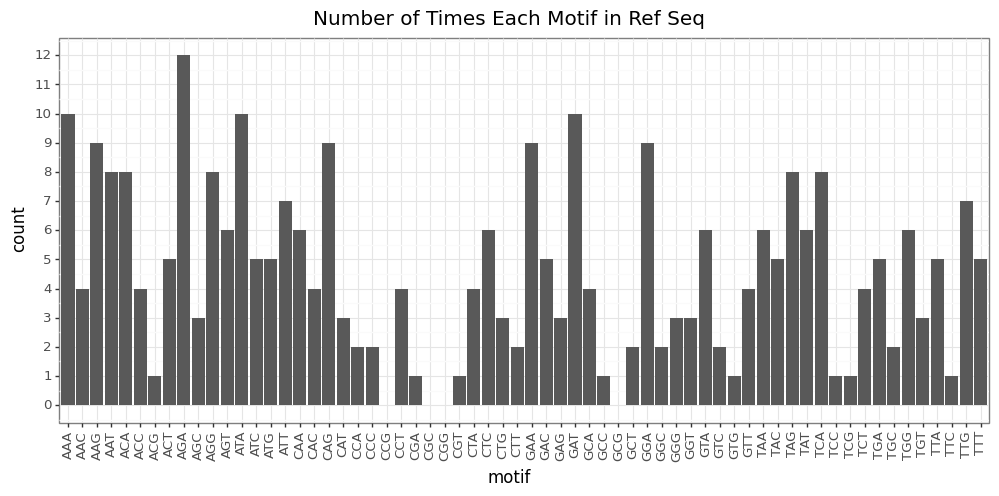

In [6]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
midrefseq = trimmedrefseq[130:170]
refseq_motif_counts = motif_counts(trimmedrefseq)
baseline_motif_counts_df = pd.DataFrame.from_dict(refseq_motif_counts, orient='index', columns=['count']).sort_values('count')
baseline_motif_counts_df = baseline_motif_counts_df.reset_index().rename(columns={'index': 'motif'})

plot_motif_counts = (ggplot(baseline_motif_counts_df, aes(x='motif', y='count')) +
                     geom_bar(stat='identity') + 
                     scale_y_continuous(breaks=range(0, 13, 1)) + 
                     labs(title='Number of Times Each Motif in Ref Seq') +
                     theme(axis_text_x=element_text(angle=90),
                           figure_size=(12, 5),
                          )
                    )

_ = plot_motif_counts.draw()

### Make 'mutinfo' `csv` files.

These `.csv`s contain information about the number and identity of mutations in each read. Store this data as `.csv` files for ease of further analyses and for examining outside of this notebook.

In [11]:
# deal with '-' and '_' discrepencies in sample names
df_samplenames = []
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)


# csvs of processed reads with mutation information placed in this directory
csvsdir1 = os.path.join(resultsdir1, 'mutinfo_csvs')
if not os.path.isdir(csvsdir1):
    os.mkdir(csvsdir1)



In [8]:
def process_bcinfo_csv(bcinfo_csv, out_dir):
    """Process bcinfo csv into mutinfo csv."""
    bcinfo_df = pd.read_csv(bcinfo_csv)
    bcinfo_df_retained = bcinfo_df[bcinfo_df['Retained'] == True].reset_index(drop=True)
    bcinfo_df_retained['mid_seq'] = bcinfo_df_retained['Consensus'].apply(lambda x: x[130:170])
    bcinfo_df_retained['mid_subs'] = bcinfo_df_retained['mid_seq'].apply(getSubstitutions_Nokay_maskG, args=(midrefseq,))
    bcinfo_df_retained['n_mid_subs'] = bcinfo_df_retained['mid_subs'].apply(get_n_subs)     
    bcinfo_df_retained['subs'] = bcinfo_df_retained['Consensus'].apply(getSubstitutions_Nokay, args=(trimmedrefseq,))
    bcinfo_df_retained['n_subs'] = bcinfo_df_retained['subs'].apply(get_n_subs)
    bcinfo_df_retained['n_ga_subs'] = bcinfo_df_retained['subs'].apply(get_n_ga_subs)
    bcinfo_df_retained['sub_tups'] = bcinfo_df_retained['subs'].apply(subs_to_motifs, args=(trimmedrefseq,))
    bcinfo_df_retained['Sample'] = [sample]*len(bcinfo_df_retained)
    bcinfo_df_retained.to_csv(f"{out_dir}/{sample}.csv") 
    
def make_mutinfo_csv(sample, in_dir, out_dir, overwrite=False):
    if not path.exists(f"{out_dir}/{sample}.csv"):
        print(f"Making mutinfo csv for {sample}...")
        process_bcinfo_csv(f"{in_dir}/{sample}_bcinfo.csv.gz", out_dir)
    elif overwrite:
        print(f"Overwriting previous mutinfo csv for {sample}...")
        process_bcinfo_csv(f"{in_dir}/{sample}_bcinfo.csv.gz")
    else:
        print(f"Mutinfo csv already exists for {sample}.")

In [12]:
for sample in df_samplenames:
    make_mutinfo_csv(sample, csvsdir1, csvsdir1, overwrite=False)

Mutinfo csv already exists for PlasmidCtrl.
Mutinfo csv already exists for NoA3.
Mutinfo csv already exists for A3G.
Mutinfo csv already exists for A3C.
Mutinfo csv already exists for A3C-I188.
Mutinfo csv already exists for A3H-hapI.
Mutinfo csv already exists for A3H-hapII.
Mutinfo csv already exists for A3C-A3C.
Mutinfo csv already exists for A3C-A3H-hapII.
Mutinfo csv already exists for A3H-hapII-A3C.
Mutinfo csv already exists for A3C-I188-A3H-hapII.
Mutinfo csv already exists for A3H-hapII-A3C-I188.


### Read in data and filter on the number of mutations in the middle of the sequence

In [13]:
mutinfo_dfs = {}
sub_count_dfs = {}
ga_sub_count_dfs = {}
for sample in df_samplenames:
    print(f"Reading in data for {sample}...")
    sample_mutinfo_df = pd.read_csv(f"{csvsdir}/{sample}.csv").fillna(value='')
    sample_mutinfo_df = sample_mutinfo_df[sample_mutinfo_df['n_mid_subs'] <= 3]
    sub_count_df = pd.DataFrame({'n_sub_count': sample_mutinfo_df.groupby('n_subs').size()}).reset_index()
    sub_count_df['n_sub_freq'] = sub_count_df['n_sub_count'] / sum(sub_count_df['n_sub_count'])
    ga_sub_count_df = pd.DataFrame({'n_ga_sub_count': sample_mutinfo_df.groupby('n_ga_subs').size()}).reset_index()
    ga_sub_count_df['n_ga_sub_freq'] = ga_sub_count_df['n_ga_sub_count'] / sum(ga_sub_count_df['n_ga_sub_count'])
    ga_sub_count_dfs[sample] = ga_sub_count_df
    sub_count_dfs[sample] = sub_count_df    
    mutinfo_dfs[sample] = sample_mutinfo_df

Reading in data for PlasmidCtrl...
Reading in data for NoA3...
Reading in data for A3G...
Reading in data for A3C...
Reading in data for A3C-I188...
Reading in data for A3H-hapI...
Reading in data for A3H-hapII...
Reading in data for A3C-A3C...
Reading in data for A3C-A3H-hapII...
Reading in data for A3H-hapII-A3C...
Reading in data for A3C-I188-A3H-hapII...
Reading in data for A3H-hapII-A3C-I188...


## Begin Sequence Analysis


In [14]:
read_count_dict = {'Sample': [], 'Total_Reads': [], 'Reads_with_Subs': [], 'Reads_with_2+_Subs': [], 
                   'Reads_with_10+_Subs': [], 'Reads_with_GA_Subs': [], 'Reads_with_2+_GA_Subs': [], 
                   'Reads_with_10+_GA_Subs': [],'%_Reads_Sub': [], '%_Reads_2+_Subs': [],
                   '%_Reads_10+_Subs': [], '%_Reads_GA_Sub': [], '%_Reads_2+_GA_Subs': [],  '%_Reads_10+_GA_Subs': []}

for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    sample_reads = len(sample_df)
    sample_sub_reads = len(sample_df[sample_df['n_subs'] > 0])
    sample_2ormoresubs_reads = len(sample_df[sample_df['n_subs'] > 1])
    sample_ga_sub_reads = len(sample_df[sample_df['n_ga_subs'] > 0])
    sample_2ormore_ga_subs_reads = len(sample_df[sample_df['n_ga_subs'] > 1])
    sample_10ormoresubs_reads = len(sample_df[sample_df['n_subs'] > 9])
    sample_10ormore_ga_subs_reads = len(sample_df[sample_df['n_ga_subs'] > 9])
    read_count_dict['Sample'].append(sample) 
    read_count_dict['Total_Reads'].append(sample_reads)
    read_count_dict['Reads_with_Subs'].append(sample_sub_reads)
    read_count_dict['Reads_with_2+_Subs'].append(sample_2ormoresubs_reads)
    read_count_dict['Reads_with_10+_Subs'].append(sample_10ormoresubs_reads)
    read_count_dict['Reads_with_GA_Subs'].append(sample_ga_sub_reads)
    read_count_dict['Reads_with_2+_GA_Subs'].append(sample_2ormore_ga_subs_reads)
    read_count_dict['Reads_with_10+_GA_Subs'].append(sample_10ormore_ga_subs_reads)
    read_count_dict['%_Reads_Sub'].append(round(sample_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_Subs'].append(round(sample_2ormoresubs_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_10+_Subs'].append(round(sample_10ormoresubs_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_GA_Sub'].append(round(sample_ga_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_GA_Subs'].append(round(sample_2ormore_ga_subs_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_10+_GA_Subs'].append(round(sample_10ormore_ga_subs_reads/sample_reads*100, 2))
read_count_df = pd.DataFrame.from_dict(read_count_dict, orient='columns')


In [15]:
display(read_count_df[['Sample','Total_Reads',
                       '%_Reads_GA_Sub','%_Reads_2+_GA_Subs', 
                       '%_Reads_10+_GA_Subs']])

,Sample,Total_Reads,%_Reads_GA_Sub,%_Reads_2+_GA_Subs,%_Reads_10+_GA_Subs
0,PlasmidCtrl,431618,2.84,0.06,0.00
1,NoA3,514722,4.69,1.42,0.39
2,A3G,199180,95.93,93.69,43.33
3,A3C,414973,32.18,12.78,0.77
4,A3C-I188,431149,54.96,33.44,1.32
5,A3H-hapI,313363,29.34,11.82,0.66
6,A3H-hapII,367013,66.05,52.36,10.71
7,A3C-A3C,242019,30.33,12.59,0.61
8,A3C-A3H-hapII,272492,55.15,38.32,2.59
9,A3H-hapII-A3C,313363,29.34,11.82,0.66


In [16]:
read_tab_dict = {'Sample': [], 'Total_Reads': [], 'Reads_with_0_Subs': [],
                 'Reads_with_1_Subs': [], 'Reads_with_2_Subs': [], 
                 'Reads_with_3_Subs': [], 'Reads_with_4_Subs': [], 
                 'Reads_with_5_Subs': [], 'Reads_with_6_Subs': [], 
                 'Reads_with_7_Subs': [], 'Reads_with_8_Subs': [], 
                 'Reads_with_9_Subs': [], 'Reads_with_10_Subs': [],
                 'Reads_over_10_Subs': []}

for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    read_tab_dict['Sample'].append(sample)
    read_tab_dict['Total_Reads'].append(len(sample_df)) 
    read_tab_dict['Reads_with_0_Subs'].append(len(sample_df[sample_df['n_subs'] == 0]))
    read_tab_dict['Reads_with_1_Subs'].append(len(sample_df[sample_df['n_subs'] == 1]))
    read_tab_dict['Reads_with_2_Subs'].append(len(sample_df[sample_df['n_subs'] == 2]))
    read_tab_dict['Reads_with_3_Subs'].append(len(sample_df[sample_df['n_subs'] == 3]))    
    read_tab_dict['Reads_with_4_Subs'].append(len(sample_df[sample_df['n_subs'] == 4]))
    read_tab_dict['Reads_with_5_Subs'].append(len(sample_df[sample_df['n_subs'] == 5]))
    read_tab_dict['Reads_with_6_Subs'].append(len(sample_df[sample_df['n_subs'] == 6]))
    read_tab_dict['Reads_with_7_Subs'].append(len(sample_df[sample_df['n_subs'] == 7]))
    read_tab_dict['Reads_with_8_Subs'].append(len(sample_df[sample_df['n_subs'] == 8]))    
    read_tab_dict['Reads_with_9_Subs'].append(len(sample_df[sample_df['n_subs'] == 9]))
    read_tab_dict['Reads_with_10_Subs'].append(len(sample_df[sample_df['n_subs'] == 10])) 
    read_tab_dict['Reads_over_10_Subs'].append(len(sample_df[sample_df['n_subs'] > 10])) 
    

read_tab_df = pd.DataFrame.from_dict(read_tab_dict, orient='columns')


In [17]:
display(read_tab_df)

,Sample,Total_Reads,Reads_with_0_Subs,Reads_with_1_Subs,Reads_with_2_Subs,Reads_with_3_Subs,Reads_with_4_Subs,Reads_with_5_Subs,Reads_with_6_Subs,Reads_with_7_Subs,Reads_with_8_Subs,Reads_with_9_Subs,Reads_with_10_Subs,Reads_over_10_Subs
0,PlasmidCtrl,431618,232069,151048,41101,6595,693,62,6,1,0,0,0,43
1,NoA3,514722,475572,30702,3606,1016,480,296,223,201,206,187,192,2041
2,A3G,199180,7195,4834,6007,8394,10685,12971,14224,15790,15714,15295,14336,73735
3,A3C,414973,272024,86374,31093,11923,4920,2289,1191,764,584,452,395,2964
4,A3C-I188,431149,187762,95143,59901,36164,20656,11447,6604,3809,2242,1377,1034,5010
5,A3H-hapI,313363,212354,60865,20708,8778,3985,2018,1082,629,376,256,195,2117
6,A3H-hapII,367013,104842,59400,37370,28859,24166,19161,16153,13743,12102,9460,6846,34911
7,A3C-A3C,242019,162313,47171,17253,6874,3205,1491,937,576,382,268,239,1310
8,A3C-A3H-hapII,272492,107862,53277,33273,22718,16105,11117,8025,5406,4100,3004,1875,5730
9,A3H-hapII-A3C,313363,212354,60865,20708,8778,3985,2018,1082,629,376,256,195,2117


In [18]:
read_pct_df = read_tab_df.copy()
for col in read_pct_df.columns.drop(['Sample','Total_Reads']):
    read_pct_df[col] = round(read_pct_df[col]/read_pct_df['Total_Reads']*100, 2)


In [19]:
display(read_pct_df)

,Sample,Total_Reads,Reads_with_0_Subs,Reads_with_1_Subs,Reads_with_2_Subs,Reads_with_3_Subs,Reads_with_4_Subs,Reads_with_5_Subs,Reads_with_6_Subs,Reads_with_7_Subs,Reads_with_8_Subs,Reads_with_9_Subs,Reads_with_10_Subs,Reads_over_10_Subs
0,PlasmidCtrl,431618,53.77,35.00,9.52,1.53,0.16,0.01,0.00,0.00,0.00,0.00,0.00,0.01
1,NoA3,514722,92.39,5.96,0.70,0.20,0.09,0.06,0.04,0.04,0.04,0.04,0.04,0.40
2,A3G,199180,3.61,2.43,3.02,4.21,5.36,6.51,7.14,7.93,7.89,7.68,7.20,37.02
3,A3C,414973,65.55,20.81,7.49,2.87,1.19,0.55,0.29,0.18,0.14,0.11,0.10,0.71
4,A3C-I188,431149,43.55,22.07,13.89,8.39,4.79,2.65,1.53,0.88,0.52,0.32,0.24,1.16
5,A3H-hapI,313363,67.77,19.42,6.61,2.80,1.27,0.64,0.35,0.20,0.12,0.08,0.06,0.68
6,A3H-hapII,367013,28.57,16.18,10.18,7.86,6.58,5.22,4.40,3.74,3.30,2.58,1.87,9.51
7,A3C-A3C,242019,67.07,19.49,7.13,2.84,1.32,0.62,0.39,0.24,0.16,0.11,0.10,0.54
8,A3C-A3H-hapII,272492,39.58,19.55,12.21,8.34,5.91,4.08,2.95,1.98,1.50,1.10,0.69,2.10
9,A3H-hapII-A3C,313363,67.77,19.42,6.61,2.80,1.27,0.64,0.35,0.20,0.12,0.08,0.06,0.68


## Combine technical replicates

In [20]:
plasmid_read_counts = read_count_df.iloc[0]
read_count_df_rep1 = read_count_df.iloc[1:12].copy()
read_count_df_rep1 = read_count_df_rep1.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

read_count_df_rep2 = read_count_df.iloc[12:].copy()
read_count_df_rep2['Sample'] = read_count_df_rep2['Sample'].str[:-2]
samples2 = read_count_df_rep2['Sample']
read_count_df_rep2 = read_count_df_rep2.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

for col in ['Total_Reads', 'Reads_with_Subs', 'Reads_with_2+_Subs', 'Reads_with_GA_Subs', 'Reads_with_2+_GA_Subs']:
    read_count_df_rep1[col] = read_count_df_rep1[col].astype(int)
    read_count_df_rep2[col] = read_count_df_rep2[col].astype(int)


read_counts_reps_summed = pd.concat([read_count_df_rep1, read_count_df_rep2]).groupby(['Sample']).sum().reset_index()
read_counts_reps_summed['%_Reads_Sub'] = round((read_counts_reps_summed['Reads_with_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_Subs'] = round((read_counts_reps_summed['Reads_with_2+_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_GA_Sub'] = round((read_counts_reps_summed['Reads_with_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_GA_Subs'] = round((read_counts_reps_summed['Reads_with_2+_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed = read_counts_reps_summed.append(plasmid_read_counts)


In [21]:
display(read_counts_reps_summed)

,Sample,Total_Reads,Reads_with_Subs,Reads_with_2+_Subs,Reads_with_10+_Subs,Reads_with_GA_Subs,Reads_with_2+_GA_Subs,Reads_with_10+_GA_Subs,%_Reads_10+_Subs,%_Reads_10+_GA_Subs,%_Reads_Sub,%_Reads_2+_Subs,%_Reads_GA_Sub,%_Reads_2+_GA_Subs
0,A3C,414973,142949,56575,3359,133556,53043,3189,0.81,0.77,34.45,13.63,32.18,12.78
1,A3C-A3C,242019,79706,32535,1549,73409,30467,1484,0.64,0.61,32.93,13.44,30.33,12.59
2,A3C-A3H-hapII,272492,164630,111353,7605,150272,104419,7062,2.79,2.59,60.42,40.86,55.15,38.32
3,A3C-I188,431149,243387,148244,6044,236948,144194,5674,1.40,1.32,56.45,34.38,54.96,33.44
4,A3C-I188-A3H-hapII,422130,298673,228059,25569,276198,214868,23653,6.06,5.60,70.75,54.03,65.43,50.90
5,A3G,199180,191985,187151,88071,191083,186620,86299,44.22,43.33,96.39,93.96,95.93,93.69
6,A3H-hapI,313363,101009,40144,2312,91954,37035,2054,0.74,0.66,32.23,12.81,29.34,11.82
7,A3H-hapII,367013,262171,202771,41757,242398,192186,39322,11.38,10.71,71.43,55.25,66.05,52.36
8,A3H-hapII-A3C,313363,101009,40144,2312,91954,37035,2054,0.74,0.66,32.23,12.81,29.34,11.82
9,A3H-hapII-A3C-I188,393795,277005,219636,46256,259273,210816,44041,11.75,11.18,70.34,55.77,65.84,53.53


# Make bar plots of # templates (y-axis) vs mutation count per template (x-axis) for each sample. 

Subset on G-to-A mutations

In [22]:
all_samples_df = pd.DataFrame()
for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    all_samples_df = all_samples_df.append(sample_df, ignore_index=True)


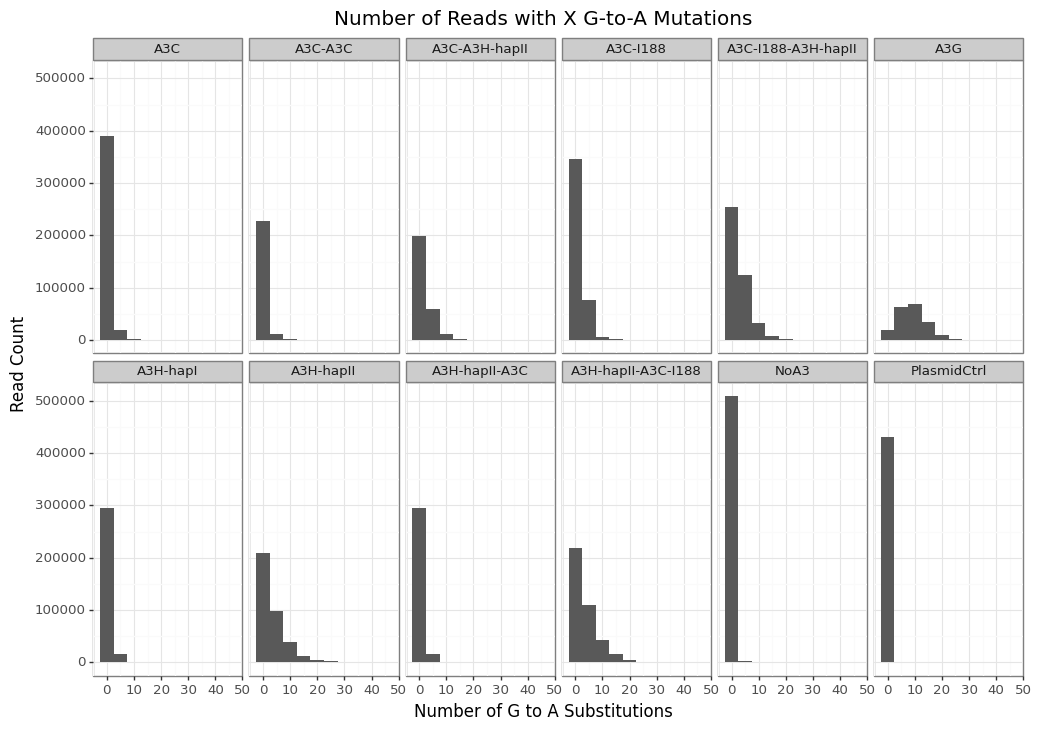

In [23]:
mut_ga_count_plot = (ggplot(all_samples_df, aes(x='n_ga_subs')) +
                  geom_histogram(binwidth=5) + 
                  facet_wrap('~ Sample', ncol=6) +
                  labs(title='Number of Reads with X G-to-A Mutations') +
                  ylab('Read Count') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=0),
                        figure_size=(12, 8),
                       )
                  )
_ = mut_ga_count_plot.draw()

In [24]:
all_samples_df_rename = all_samples_df.copy()

ignore = ['A3C-I188','A3H-hapI','A3H-hapII-A3C-I188','A3C-I188-A3H-hapII']

all_samples_df_rename = all_samples_df_rename.loc[~all_samples_df_rename['Sample'].isin(ignore), :]
all_samples_df_rename = all_samples_df_rename.loc[~all_samples_df_rename['Sample'].isin(ignore), :]

all_samples_df_rename['Sample'] = all_samples_df_rename['Sample'].map({'PlasmidCtrl':'01_PlasmidCtrl',
                                                                      'NoA3':'02_NoA3',
                                                                      'A3G':'03_A3G',
                                                                      'A3H-hapII':'04_A3H-hapII',
                                                                      'A3C':'05_A3C',
                                                                      'A3C-A3C':'06_A3C-A3C',
                                                                      'A3C-A3H-hapII':'07_A3C-A3H-hapII',
                                                                      'A3H-hapII-A3C':'08_A3H-hapII-A3C'})
facet_dict_ga = {'01_PlasmidCtrl': f"Plasmid Ctrl", '02_NoA3': f"No A3", 
                 '03_A3G': f"A3G", '04_A3H-hapII': f"A3H hapII",
                 '05_A3C': f"A3C", '06_A3C-A3C': f"A3C-A3C", 
                 '07_A3C-A3H-hapII': f"A3C-A3H hapII", '08_A3H-hapII-A3C': f"A3H hapII-A3C"}



facet_cat = pd.Categorical(all_samples_df_rename['Sample'], categories=all_samples_df_rename['Sample'].unique().tolist())
all_samples_df_rename = all_samples_df_rename.assign(facet_cat = facet_cat)

def facet_labeller(label):
    return(facet_dict_ga[label])


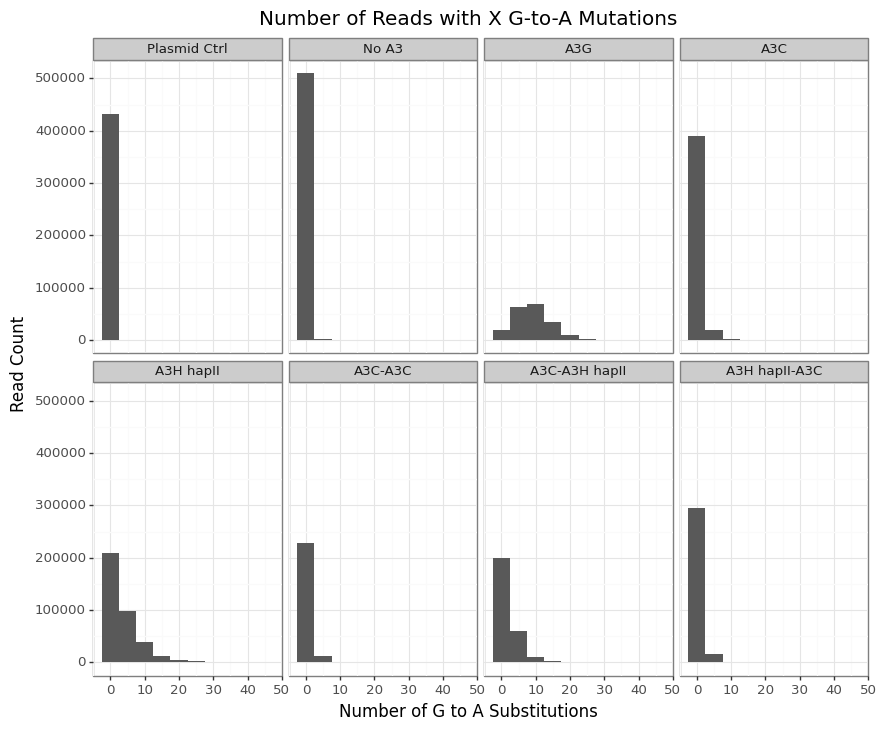

In [25]:
mut_ga_count_plot = (ggplot(all_samples_df_rename, aes(x='n_ga_subs')) +
                  geom_histogram(binwidth=5) + 
                  facet_wrap('~facet_cat', ncol=4, labeller=facet_labeller) +
                  labs(title='Number of Reads with X G-to-A Mutations') +
                  ylab('Read Count') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=0),
                        figure_size=(10, 8),
                       )
                  )
_ = mut_ga_count_plot.draw()

## Frequency of reads for each sample with that number of substitutions rather than count.

Still subsetting on G-to-A mutations.

As seen above, technical replicates have same distributions, just different count numbers. So averaging
frequencies between replicates.

In [26]:
all_ga_sub_counts_df = pd.DataFrame()
rep1_ga_sub_counts_df = pd.DataFrame()
rep2_ga_sub_counts_df = pd.DataFrame()
for sample in df_samplenames:
    sample_binned_dict = {}
    sample_df = ga_sub_count_dfs[sample]
    for i in range(0, 10):
        if i in sample_df['n_ga_subs'].to_list():
            idx = sample_df.index[sample_df['n_ga_subs'] == i][0]
            sample_binned_dict[str(i)] = sample_df.at[idx, 'n_ga_sub_count']
        else:
            sample_binned_dict[str(i)] = 0
    sample_binned_dict['10+'] = sum(sample_df[sample_df['n_ga_subs'] >= 10]['n_ga_sub_count'])
    assert(sum(sample_df['n_ga_sub_count']) == sum(sample_binned_dict.values()))
    sample_binned_df = pd.DataFrame.from_dict(sample_binned_dict, orient='index').reset_index().rename(columns={'index': 'n_ga_subs', 0: 'n_ga_sub_count'})
    sample_binned_df['n_ga_sub_freq'] = sample_binned_df['n_ga_sub_count'] / sum(sample_binned_df['n_ga_sub_count']) * 100
    sample_binned_df['Sample'] = [sample]*len(sample_binned_df)
    if sample == 'PlasmidCtrl':
        plasmid_binned_df = sample_binned_df
    else:
        rep1_ga_sub_counts_df = rep1_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)

reps_ga_concat = pd.concat((rep1_ga_sub_counts_df, rep2_ga_sub_counts_df))
ga_by_row_index = reps_ga_concat.groupby(reps_ga_concat.index)
reps_ga_avg = pd.DataFrame()
reps_ga_avg['n_ga_sub_freq'] = ga_by_row_index['n_ga_sub_freq'].mean()
reps_ga_avg['n_ga_sub_count'] = ga_by_row_index['n_ga_sub_count'].sum()
reps_ga_avg['n_ga_subs'] = rep1_ga_sub_counts_df['n_ga_subs']
reps_ga_avg['Sample'] = rep1_ga_sub_counts_df['Sample']
    
    
all_ga_sub_counts_df = pd.concat((reps_ga_avg, plasmid_binned_df), ignore_index=True, sort=True)


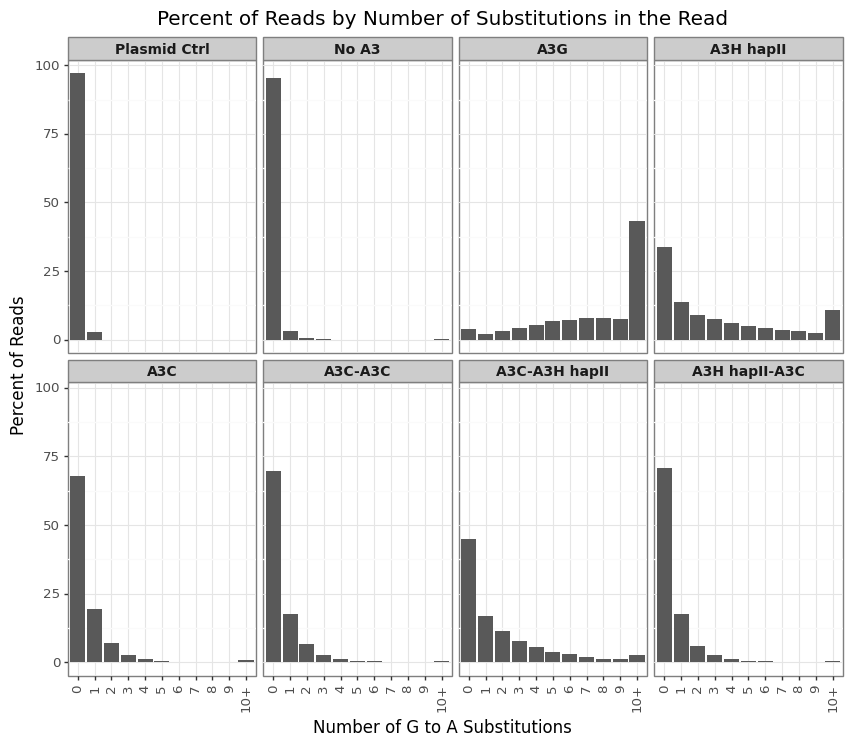

In [27]:
all_ga_sub_counts_df_rename = all_ga_sub_counts_df.copy()
ignore = ['A3C-I188','A3H-hapI','A3H-hapII-A3C-I188','A3C-I188-A3H-hapII']
all_ga_sub_counts_df_rename = all_ga_sub_counts_df_rename.loc[~all_ga_sub_counts_df_rename['Sample'].isin(ignore), :]


all_ga_sub_counts_df_rename['Sample'] = all_ga_sub_counts_df_rename['Sample'].map({'PlasmidCtrl':'01_PlasmidCtrl',
                                                                      'NoA3':'02_NoA3',
                                                                      'A3G':'03_A3G',
                                                                      'A3H-hapII':'04_A3H-hapII',
                                                                      'A3C':'05_A3C',
                                                                      'A3C-A3C':'06_A3C-A3C',
                                                                      'A3C-A3H-hapII':'07_A3C-A3H-hapII',
                                                                      'A3H-hapII-A3C':'08_A3H-hapII-A3C'})
all_ga_sub_counts_df_rename = all_ga_sub_counts_df_rename.sort_values('Sample')
facet_dict_ga = {'01_PlasmidCtrl': f"Plasmid Ctrl", '02_NoA3': f"No A3", 
                 '03_A3G': f"A3G", '04_A3H-hapII': f"A3H hapII",
                 '05_A3C': f"A3C", '06_A3C-A3C': f"A3C-A3C", 
                 '07_A3C-A3H-hapII': f"A3C-A3H hapII", '08_A3H-hapII-A3C': f"A3H hapII-A3C"}



facet_cat = pd.Categorical(all_samples_df_rename['Sample'], categories=all_samples_df_rename['Sample'].unique().tolist())

x_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
x_cat = pd.Categorical(all_ga_sub_counts_df_rename['n_ga_subs'], categories=x_list)


facet_cat = pd.Categorical(all_ga_sub_counts_df_rename['Sample'], 
                           categories=all_ga_sub_counts_df_rename['Sample'].unique().tolist())

def facet_labeller(label):
    return(facet_dict_ga[label])

all_ga_sub_counts_df_rename = all_ga_sub_counts_df_rename.assign(x_cat = x_cat)
all_ga_sub_counts_df_rename = all_ga_sub_counts_df_rename.assign(facet_cat = facet_cat)
ga_mut_freq_plot = (ggplot(all_ga_sub_counts_df_rename, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~facet_cat', ncol=4, labeller=facet_labeller) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(10, 8),
                        strip_text_x = element_text(size = 10, weight='bold')
                       )
                  )

_ = ga_mut_freq_plot.draw()

#### Isolated plots for viewing

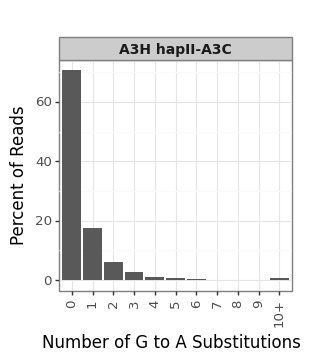

In [28]:
i = 8
sub_df = all_ga_sub_counts_df_rename.loc[all_ga_sub_counts_df_rename['Sample'].str.startswith('0'+str(i)),:]

ga_mut_freq_subplot = (ggplot(sub_df, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~facet_cat', ncol=4, labeller=facet_labeller) +
                  labs(title=' ') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=90),
                        figure_size=(3, 3),
                        strip_text_x = element_text(size = 10, weight='bold')
                       )
                  )

_ = ga_mut_freq_subplot.draw()

# Experiment 2

In [30]:
samplenames = ['A3C-A3H2-1', 'A3C-A3H2-2', 'A3C-A3H2-3', 
               'A3G-1', 'A3G-2', 'A3G-3',
               'NoA3-1', 'NoA3-2','NoA3-3',
               'PlasmidCtrl']
R1_df = pd.DataFrame({'name':samplenames})
R1_df["R1"] = R1_df['name'].astype(str) + "_R1.fastq.gz"
R1_df["name"] = R1_df['name'].str.replace("_", "-")

print(R1_df)

          name                       R1
0   A3C-A3H2-1   A3C-A3H2-1_R1.fastq.gz
1   A3C-A3H2-2   A3C-A3H2-2_R1.fastq.gz
2   A3C-A3H2-3   A3C-A3H2-3_R1.fastq.gz
3        A3G-1        A3G-1_R1.fastq.gz
4        A3G-2        A3G-2_R1.fastq.gz
5        A3G-3        A3G-3_R1.fastq.gz
6       NoA3-1       NoA3-1_R1.fastq.gz
7       NoA3-2       NoA3-2_R1.fastq.gz
8       NoA3-3       NoA3-3_R1.fastq.gz
9  PlasmidCtrl  PlasmidCtrl_R1.fastq.gz


In [31]:
fastqdir2 = "./results/FASTQ_files/"
refseq = './data/Bru_Pol.fasta'

# define subamplicon alignment specifications
alignspecs = ' '.join(['205,504,35,34']) 

# counts and alignments placed in this directory
countsdir2 = os.path.join(resultsdir2, 'codoncounts')
if not os.path.isdir(countsdir2):
    os.mkdir(countsdir2)
    
# write sample information to a batch file for dms2_batch_bcsubamplicons
countsbatchfile = os.path.join(countsdir2, 'batch.csv')
print("Here is the batch file that we write to CSV format to use as input:")
display(HTML(R1_df[['name', 'R1']].to_html(index=False)))
R1_df[['name', 'R1']].to_csv(countsbatchfile, index=False)

#we will only look at sites sequenced
sitemaskfile = "./data/sitemask.csv"

Here is the batch file that we write to CSV format to use as input:


name,R1
A3C-A3H2-1,A3C-A3H2-1_R1.fastq.gz
A3C-A3H2-2,A3C-A3H2-2_R1.fastq.gz
A3C-A3H2-3,A3C-A3H2-3_R1.fastq.gz
A3G-1,A3G-1_R1.fastq.gz
A3G-2,A3G-2_R1.fastq.gz
A3G-3,A3G-3_R1.fastq.gz
NoA3-1,NoA3-1_R1.fastq.gz
NoA3-2,NoA3-2_R1.fastq.gz
NoA3-3,NoA3-3_R1.fastq.gz
PlasmidCtrl,PlasmidCtrl_R1.fastq.gz


In [32]:
#here, we need to allow for a large number of mismatches if the sequence was in fact hypermutated
print('\nNow running dms2_batch_bcsubamp...')
log = !dms2_batch_bcsubamp \
        --batchfile {countsbatchfile} \
        --refseq {refseq} \
        --alignspecs {alignspecs} \
        --outdir {countsdir2} \
        --summaryprefix summary \
        --R1trim 200 \
        --R2trim 170 \
        --minq 17 \
        --fastqdir {fastqdir2} \
        --maxmuts 33 \
        --sitemask {sitemaskfile} \
        --ncpus {ncpus} \
        --bcinfo \
        --bcinfo_csv \
        --use_existing {use_existing} 
print("Completed dms2_batch_bcsubamp.")


Now running dms2_batch_bcsubamp...
Completed dms2_batch_bcsubamp.


## Define and examine reference sequence

The sequenced region of *pol* is defined as `trimmedrefseq`. 

We also look at the frequency of each 3-nucleotide motif. As seen, some 3-nt motifs do not exist in this sequence, but all nucleotides are present at least once as the 5' or 3' nucleotide in a motif. 

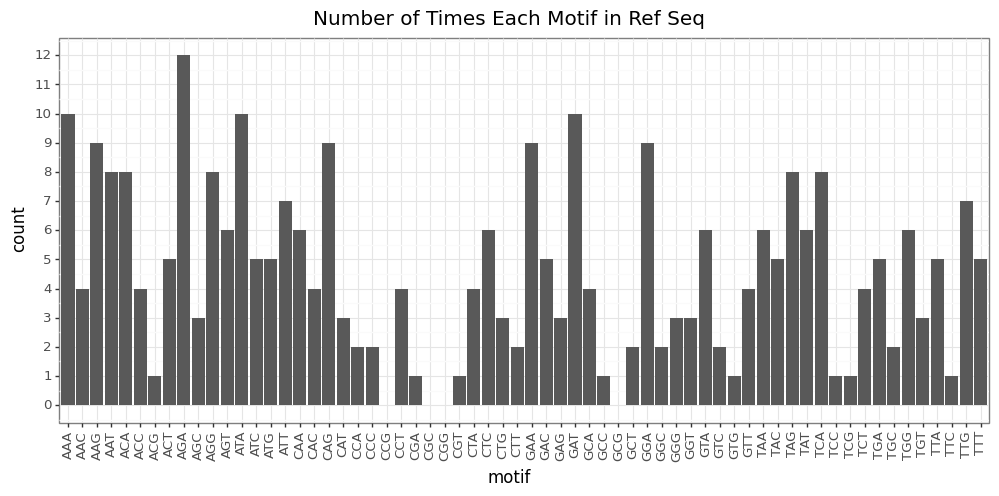

In [33]:
trimmedrefseq = "CCTCAGATCACTCTTTGGCAACGACCCCTCGTCACAATAAAGATAGGGGGGCAACTAAAGGAAGCTCTATTAGATACAGGAGCAGATGATACAGTATTAGAAGAAATGAGTTTGCCAGGAAGATGGAAACCAAAAATGATAGGGGGAATTGGAGGTTTTATCAAAGTAAGACAGTATGATCAGATACTCATAGAAATCTGTGGACATAAAGCTATAGGTACAGTATTAGTAGGACCTACACCTGTCAACATAATTGGAAGAAATCTGTTGACTCAGATTGGTTGCACTTTAAATTTTCCC"
midrefseq = trimmedrefseq[130:170]
refseq_motif_counts = motif_counts(trimmedrefseq)
baseline_motif_counts_df = pd.DataFrame.from_dict(refseq_motif_counts, orient='index', columns=['count']).sort_values('count')
baseline_motif_counts_df = baseline_motif_counts_df.reset_index().rename(columns={'index': 'motif'})

plot_motif_counts = (ggplot(baseline_motif_counts_df, aes(x='motif', y='count')) +
                     geom_bar(stat='identity') + 
                     scale_y_continuous(breaks=range(0, 13, 1)) + 
                     labs(title='Number of Times Each Motif in Ref Seq') +
                     theme(axis_text_x=element_text(angle=90),
                           figure_size=(12, 5),
                          )
                    )

_ = plot_motif_counts.draw()

## Make 'mutinfo' `csv` files.

These `.csv`s contain information about the number and identity of mutations in each read. Store this data as `.csv` files for ease of further analyses and for examining outside of this notebook.

In [34]:
# deal with '-' and '_' discrepencies in sample names
df_samplenames = []
for sample in samplenames:
    df_samplename = sample.replace('_', '-')
    df_samplenames.append(df_samplename)

# csvs of processed reads with mutation information placed in this directory
csvsdir = os.path.join(resultsdir2, 'mutinfo_csvs')
if not os.path.isdir(csvsdir):
    os.mkdir(csvsdir)
    
for sample in df_samplenames:
    make_mutinfo_csv(sample, countsdir, csvsdir, overwrite=False)
    


Mutinfo csv already exists for A3C-A3H2-1.
Mutinfo csv already exists for A3C-A3H2-2.
Mutinfo csv already exists for A3C-A3H2-3.
Mutinfo csv already exists for A3G-1.
Mutinfo csv already exists for A3G-2.
Mutinfo csv already exists for A3G-3.
Mutinfo csv already exists for NoA3-1.
Mutinfo csv already exists for NoA3-2.
Mutinfo csv already exists for NoA3-3.
Mutinfo csv already exists for PlasmidCtrl.


## Read in data and filter on the number of mutations in the middle of the sequence

In [35]:
mutinfo_dfs = {}
sub_count_dfs = {}
ga_sub_count_dfs = {}
for sample in df_samplenames:
    print(f"Reading in data for {sample}...")
    sample_mutinfo_df = pd.read_csv(f"{csvsdir}/{sample}.csv").fillna(value='')
    sample_mutinfo_df = sample_mutinfo_df[sample_mutinfo_df['n_mid_subs'] <= 3]
    sub_count_df = pd.DataFrame({'n_sub_count': sample_mutinfo_df.groupby('n_subs').size()}).reset_index()
    sub_count_df['n_sub_freq'] = sub_count_df['n_sub_count'] / sum(sub_count_df['n_sub_count'])
    ga_sub_count_df = pd.DataFrame({'n_ga_sub_count': sample_mutinfo_df.groupby('n_ga_subs').size()}).reset_index()
    ga_sub_count_df['n_ga_sub_freq'] = ga_sub_count_df['n_ga_sub_count'] / sum(ga_sub_count_df['n_ga_sub_count'])
    ga_sub_count_dfs[sample] = ga_sub_count_df
    sub_count_dfs[sample] = sub_count_df    
    mutinfo_dfs[sample] = sample_mutinfo_df

Reading in data for A3C-A3H2-1...
Reading in data for A3C-A3H2-2...
Reading in data for A3C-A3H2-3...
Reading in data for A3G-1...
Reading in data for A3G-2...
Reading in data for A3G-3...
Reading in data for NoA3-1...
Reading in data for NoA3-2...
Reading in data for NoA3-3...
Reading in data for PlasmidCtrl...


## Begin Sequence Analysis

In [36]:
read_count_dict = {'Sample': [], 'Total_Reads': [], 'Reads_with_Subs': [], 'Reads_with_2+_Subs': [],
                   'Reads_with_GA_Subs': [], 'Reads_with_2+_GA_Subs': [], '%_Reads_Sub': [], 
                   '%_Reads_2+_Subs': [], '%_Reads_GA_Sub': [], '%_Reads_2+_GA_Subs': []}

for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    sample_reads = len(sample_df)
    sample_sub_reads = len(sample_df[sample_df['n_subs'] > 0])
    sample_2ormoresubs_reads = len(sample_df[sample_df['n_subs'] > 1])
    sample_ga_sub_reads = len(sample_df[sample_df['n_ga_subs'] > 0])
    sample_2ormore_ga_subs_reads = len(sample_df[sample_df['n_ga_subs'] > 1])
    read_count_dict['Sample'].append(sample) 
    read_count_dict['Total_Reads'].append(sample_reads)
    read_count_dict['Reads_with_Subs'].append(sample_sub_reads)
    read_count_dict['Reads_with_2+_Subs'].append(sample_2ormoresubs_reads)
    read_count_dict['Reads_with_GA_Subs'].append(sample_ga_sub_reads)
    read_count_dict['Reads_with_2+_GA_Subs'].append(sample_2ormore_ga_subs_reads)
    read_count_dict['%_Reads_Sub'].append(round(sample_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_Subs'].append(round(sample_2ormoresubs_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_GA_Sub'].append(round(sample_ga_sub_reads/sample_reads*100, 2))
    read_count_dict['%_Reads_2+_GA_Subs'].append(round(sample_2ormore_ga_subs_reads/sample_reads*100, 2))
read_count_df = pd.DataFrame.from_dict(read_count_dict, orient='columns')


In [37]:
perc_cols = read_count_df.columns[read_count_df.columns.str.startswith('%')].tolist()
read_count_df.loc[:,perc_cols]

,%_Reads_Sub,%_Reads_2+_Subs,%_Reads_GA_Sub,%_Reads_2+_GA_Subs
0,47.26,33.47,45.88,31.62
1,59.46,43.51,57.86,41.78
2,58.01,43.12,56.80,40.98
3,48.59,41.54,48.09,39.96
4,55.64,51.53,55.17,50.00
5,57.96,53.94,57.19,46.49
6,44.98,31.04,43.27,29.80
7,43.25,27.68,40.67,26.89
8,45.21,29.16,43.55,28.62
9,1.08,0.02,0.24,0.02


## Combine technical replicates

In [38]:
plasmid_read_counts = read_count_df.loc[read_count_df['Sample']=='PlasmidCtrl']

read_count_df_rep1 = read_count_df.loc[read_count_df['Sample'].str.endswith('1')].copy()
read_count_df_rep1['Sample'] = read_count_df_rep1['Sample'].str[:-2]
read_count_df_rep1 = read_count_df_rep1.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

read_count_df_rep2 = read_count_df.loc[read_count_df['Sample'].str.endswith('2')].copy()
read_count_df_rep2['Sample'] = read_count_df_rep2['Sample'].str[:-2]
samples2 = read_count_df_rep2['Sample']
read_count_df_rep2 = read_count_df_rep2.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)

read_count_df_rep3 = read_count_df.loc[read_count_df['Sample'].str.endswith('3')].copy()
read_count_df_rep3['Sample'] = read_count_df_rep3['Sample'].str[:-2]
read_count_df_rep3 = read_count_df_rep3.drop(['%_Reads_Sub', '%_Reads_2+_Subs', '%_Reads_GA_Sub', '%_Reads_2+_GA_Subs'], axis=1)


for col in ['Total_Reads', 'Reads_with_Subs', 'Reads_with_2+_Subs', 'Reads_with_GA_Subs', 'Reads_with_2+_GA_Subs']:
    read_count_df_rep1[col] = read_count_df_rep1[col].astype(int)
    read_count_df_rep2[col] = read_count_df_rep2[col].astype(int)
    read_count_df_rep3[col] = read_count_df_rep3[col].astype(int)
    
read_counts_reps_summed = pd.concat([read_count_df_rep1, read_count_df_rep2, read_count_df_rep3]).groupby(['Sample']).sum().reset_index()
read_counts_reps_summed['%_Reads_Sub'] = round((read_counts_reps_summed['Reads_with_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_Subs'] = round((read_counts_reps_summed['Reads_with_2+_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_GA_Sub'] = round((read_counts_reps_summed['Reads_with_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed['%_Reads_2+_GA_Subs'] = round((read_counts_reps_summed['Reads_with_2+_GA_Subs'] / read_counts_reps_summed['Total_Reads'])*100, 2)
read_counts_reps_summed = read_counts_reps_summed.append(plasmid_read_counts)



In [39]:
read_counts_reps_summed.loc[:,perc_cols]

,%_Reads_Sub,%_Reads_2+_Subs,%_Reads_GA_Sub,%_Reads_2+_GA_Subs
0,54.84,40.03,53.47,38.09
1,54.69,49.80,54.08,45.71
2,44.36,28.94,42.32,28.16
9,1.08,0.02,0.24,0.02


# Make bar plots of # templates (y-axis) vs mutation count per template (x-axis) for each sample. 

Subset on G-to-A mutations

In [41]:
all_samples_df = pd.DataFrame()
for sample in df_samplenames:
    sample_df = mutinfo_dfs[sample]
    all_samples_df = all_samples_df.append(sample_df, ignore_index=True)
    

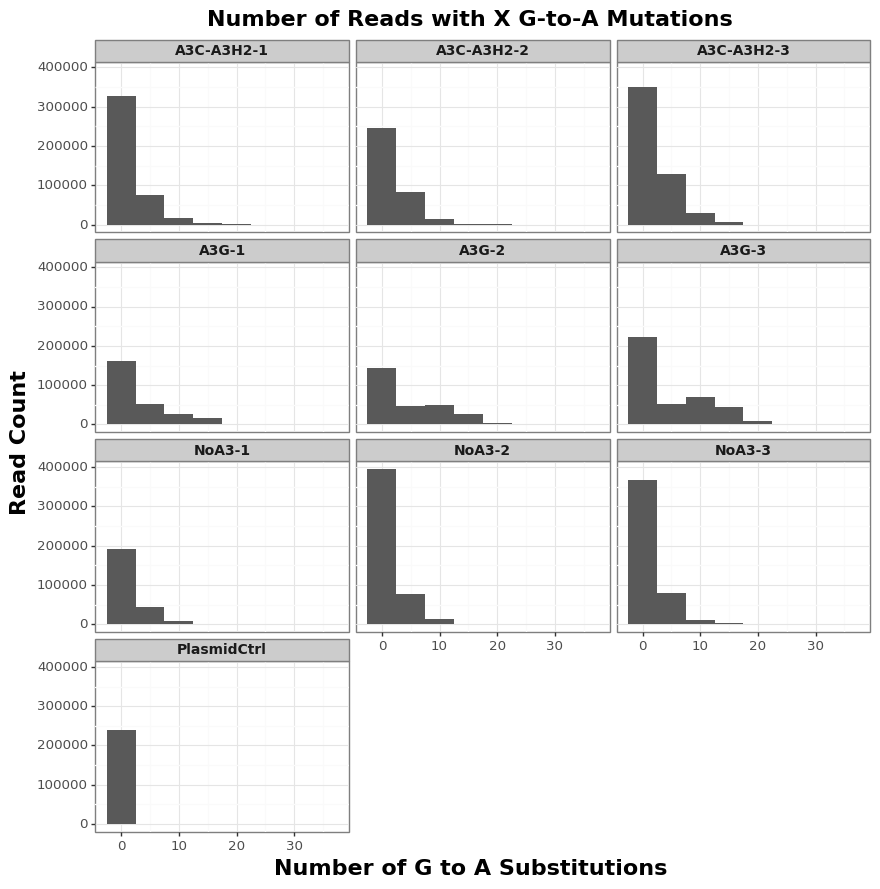

In [42]:
mut_ga_count_plot = (ggplot(all_samples_df, aes(x='n_ga_subs')) +
                  geom_histogram(binwidth=5) + 
                  facet_wrap('~ Sample', ncol=3) +
                  labs(title='Number of Reads with X G-to-A Mutations') +
                  ylab('Read Count') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=0),
                        strip_text_x = element_text(size = 10, weight='bold'),
                        axis_title=element_text(size=16, face='bold'),
                        title=element_text(size=16, face='bold'),
                        figure_size=(10, 10),
                       )
                  )
_ = mut_ga_count_plot.draw()

## Frequency of reads for each sample with that number of substitutions rather than count.

Still subsetting on G-to-A mutations.


In [43]:
all_ga_sub_counts_df = pd.DataFrame()
rep1_ga_sub_counts_df = pd.DataFrame()
rep2_ga_sub_counts_df = pd.DataFrame()
rep3_ga_sub_counts_df = pd.DataFrame()
for sample in samplenames:
    sample_binned_dict = {}
    sample_df = ga_sub_count_dfs[sample]
    for i in range(0, 10):
        if i in sample_df['n_ga_subs'].to_list():
            idx = sample_df.index[sample_df['n_ga_subs'] == i][0]
            sample_binned_dict[str(i)] = sample_df.at[idx, 'n_ga_sub_count']
        else:
            sample_binned_dict[str(i)] = 0
    sample_binned_dict['10+'] = sum(sample_df[sample_df['n_ga_subs'] >= 10]['n_ga_sub_count'])
    assert(sum(sample_df['n_ga_sub_count']) == sum(sample_binned_dict.values()))
    sample_binned_df = pd.DataFrame.from_dict(sample_binned_dict, orient='index').reset_index().rename(columns={'index': 'n_ga_subs', 0: 'n_ga_sub_count'})
    sample_binned_df['n_ga_sub_freq'] = sample_binned_df['n_ga_sub_count'] / sum(sample_binned_df['n_ga_sub_count']) * 100
    sample_binned_df['Sample'] = [sample.split('-')[0]]*len(sample_binned_df)
    if sample.upper() == 'PLASMIDCTRL':
        plasmid_binned_df = sample_binned_df
    elif '-1' in sample:
        rep1_ga_sub_counts_df = rep1_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)
    elif '-2' in sample:
        rep2_ga_sub_counts_df = rep2_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)
    elif '-3' in sample:
        rep3_ga_sub_counts_df = rep3_ga_sub_counts_df.append(sample_binned_df, ignore_index=True)

    else:
        print(f'Invalid sample name {sample}')
        break

reps_ga_concat = pd.concat((rep1_ga_sub_counts_df, rep2_ga_sub_counts_df, rep3_ga_sub_counts_df))
ga_by_row_index = reps_ga_concat.groupby(reps_ga_concat.index)
reps_ga_avg = pd.DataFrame()
reps_ga_avg['n_ga_sub_freq'] = ga_by_row_index['n_ga_sub_freq'].mean()
reps_ga_avg['n_ga_sub_count'] = ga_by_row_index['n_ga_sub_count'].sum()
reps_ga_avg['n_ga_subs'] = rep1_ga_sub_counts_df['n_ga_subs']
reps_ga_avg['Sample'] = rep1_ga_sub_counts_df['Sample']
    
    
all_ga_sub_counts_df = pd.concat((reps_ga_avg, plasmid_binned_df), ignore_index=True, sort=True)

rep1_ga_sub_counts_df['Sample'] = rep1_ga_sub_counts_df['Sample'] + '-1'
rep2_ga_sub_counts_df['Sample'] = rep2_ga_sub_counts_df['Sample'] + '-2'
rep3_ga_sub_counts_df['Sample'] = rep3_ga_sub_counts_df['Sample'] + '-3'
all_rep_sub_counts_df = pd.concat((plasmid_binned_df, rep1_ga_sub_counts_df, rep2_ga_sub_counts_df, rep3_ga_sub_counts_df))



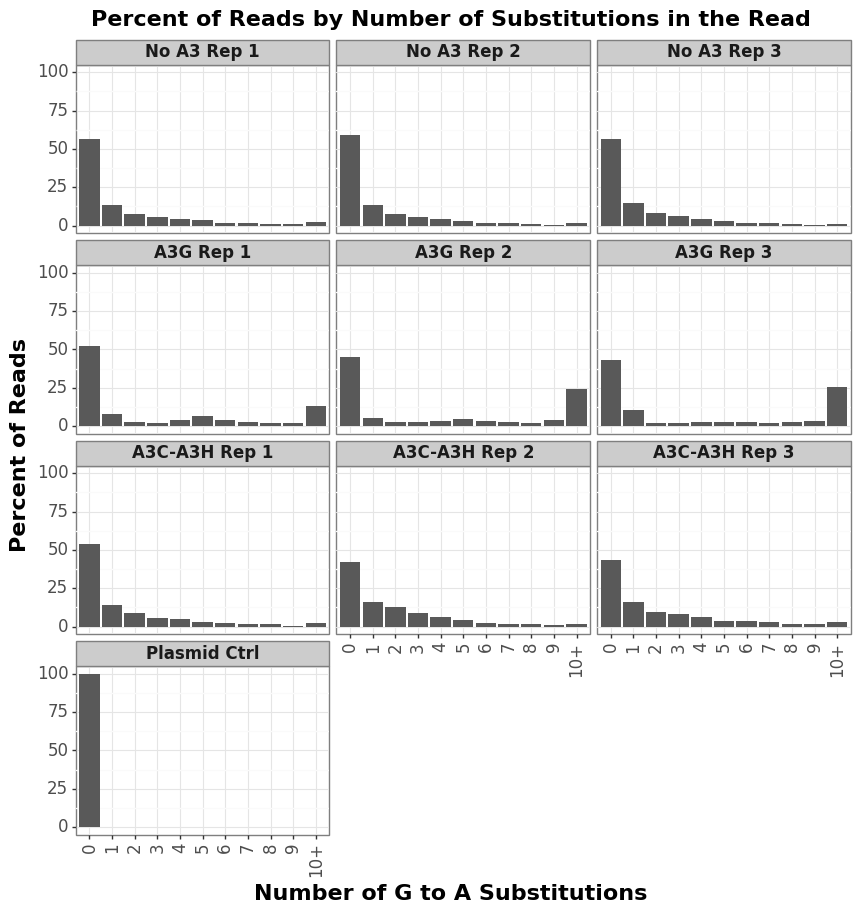

In [44]:
facet_dict_ga = {'A3C-1': f"A3C-A3H Rep 1", 'A3C-2': f"A3C-A3H Rep 2", 'A3C-3': f"A3C-A3H Rep 3",
                 'A3G-1': f"A3G Rep 1", 'A3G-2': f"A3G Rep 2", 'A3G-3': f"A3G Rep 3",
                 'NoA3-1' : f"No A3 Rep 1", 'NoA3-2' : f"No A3 Rep 2", 'NoA3-3' : f"No A3 Rep 3",
                 'PlasmidCtrl': f"Plasmid Ctrl"}

def facet_labeller_ga(label):
    return(facet_dict_ga[label])

x_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
x_cat = pd.Categorical(all_rep_sub_counts_df['n_ga_subs'], categories=x_list)

facet_list = ['NoA3-1', 'NoA3-2', 'NoA3-3', 'A3G-1', 'A3G-2', 'A3G-3', 'A3C-1', 'A3C-2', 'A3C-3', 'PlasmidCtrl']
facet_cat = pd.Categorical(all_rep_sub_counts_df['Sample'], categories=facet_list)

all_rep_sub_counts_df = all_rep_sub_counts_df.assign(x_cat = x_cat)
all_rep_sub_counts_df = all_rep_sub_counts_df.assign(facet_cat = facet_cat)


ga_mut_freq_plot = (ggplot(all_rep_sub_counts_df, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=3, labeller=facet_labeller_ga) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +

                  theme(axis_text_x=element_text(angle=90, size=12),
                        axis_text_y=element_text(size=12),
                        strip_text_x = element_text(size = 12, weight='bold'),
                        axis_title=element_text(size=16, face='bold'),
                        title=element_text(size=16, face='bold'),
                        figure_size=(10, 10),
                       )
                  )

_ = ga_mut_freq_plot.draw()

As seen above, technical replicates have same distributions, just different count numbers. So averaging
frequencies between replicates.

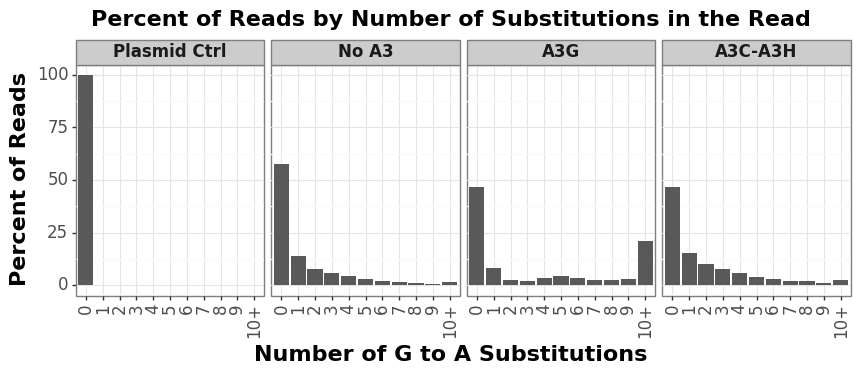

In [45]:
facet_dict_ga = {'A3C': f"A3C-A3H", 'A3G': f"A3G", 'NoA3' : f"No A3", 'PlasmidCtrl': f"Plasmid Ctrl"}

def facet_labeller_ga(label):
    return(facet_dict_ga[label])


x_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10+']
x_cat = pd.Categorical(all_ga_sub_counts_df['n_ga_subs'], categories=x_list)

facet_list = ['PlasmidCtrl', 'NoA3', 'A3G', 'A3C']
facet_cat = pd.Categorical(all_ga_sub_counts_df['Sample'], categories=facet_list)


all_ga_sub_counts_df = all_ga_sub_counts_df.assign(x_cat = x_cat)
all_ga_sub_counts_df = all_ga_sub_counts_df.assign(facet_cat = facet_cat)

ga_mut_freq_plot = (ggplot(all_ga_sub_counts_df, aes(x='x_cat', y='n_ga_sub_freq')) +
                  geom_bar(stat='identity') + 
                  facet_wrap('~ facet_cat', ncol=4, labeller=facet_labeller_ga) +
                  labs(title='Percent of Reads by Number of Substitutions in the Read') +
                  ylab('Percent of Reads') +
                  xlab('Number of G to A Substitutions') +
                  theme(axis_text_x=element_text(angle=90, size=12),
                        axis_text_y=element_text(size=12),
                        strip_text_x = element_text(size = 12, weight='bold'),
                        axis_title=element_text(size=16, face='bold'),
                        title=element_text(size=16, face='bold'),
                        figure_size=(10, 3),
                       )
                  )

_ = ga_mut_freq_plot.draw()